In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from scipy.stats import ttest_ind, chi2_contingency
from warnings import filterwarnings
filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve


In [2]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.shape

(6362620, 11)

In [5]:
df.size

69988820

##### Data Cleaning

In [6]:
# Checking duplicates

df[df.duplicated()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [7]:
col= df.columns.to_list()
col

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [8]:
# Unique items

for i in col:
    print(i)
    print(df[i].unique())
    print()
    print('*****')

step
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 2

In [9]:
# Checking Missing values

(df.isnull().sum().sum() / (df.size)) * 100

0.0

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [11]:
# Checking Outliers

exclude_cols = ['isFraud', 'isFlaggedFraud']
num = [col for col in df.select_dtypes(include='number').columns if col not in exclude_cols]

for i in num:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    LW = Q1 - 1.5 * IQR
    UW = Q3 + 1.5 * IQR
    Outliers = (df[i] < LW) | (df[i] > UW)
    
    print(i)
    print("Number of outliers:", Outliers.sum())
    print("Filtered data size (if outliers were removed):", len(df) - Outliers.sum())
    print("*" * 60)

step
Number of outliers: 102688
Filtered data size (if outliers were removed): 6259932
************************************************************
amount
Number of outliers: 338078
Filtered data size (if outliers were removed): 6024542
************************************************************
oldbalanceOrg
Number of outliers: 1112507
Filtered data size (if outliers were removed): 5250113
************************************************************
newbalanceOrig
Number of outliers: 1053391
Filtered data size (if outliers were removed): 5309229
************************************************************
oldbalanceDest
Number of outliers: 786135
Filtered data size (if outliers were removed): 5576485
************************************************************
newbalanceDest
Number of outliers: 738527
Filtered data size (if outliers were removed): 5624093
************************************************************


##### STATISTICAL TESTING

In [12]:
fraud_data = df[df['isFraud'] == 1]
nonfraud_data = df[df['isFraud'] == 0]

# T-Tests for Numerical Features
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for col in numerical_cols:
    print(f"Feature: {col}")
    print("H0: There is no significant difference in", col, "between fraud and non-fraud transactions.")
    print("H1: There is a significant difference in", col, "between fraud and non-fraud transactions.")
    
    stat, p_value = ttest_ind(fraud_data[col], nonfraud_data[col], equal_var=False)
    print(f"p-value: {p_value:.5f}")
    
    if p_value < 0.05:
        print("Result: Reject H0. Feature is statistically significant.\n")
    else:
        print("Result: Fail to reject H0. Feature may not be significant.\n")

Feature: amount
H0: There is no significant difference in amount between fraud and non-fraud transactions.
H1: There is a significant difference in amount between fraud and non-fraud transactions.
p-value: 0.00000
Result: Reject H0. Feature is statistically significant.

Feature: oldbalanceOrg
H0: There is no significant difference in oldbalanceOrg between fraud and non-fraud transactions.
H1: There is a significant difference in oldbalanceOrg between fraud and non-fraud transactions.
p-value: 0.00000
Result: Reject H0. Feature is statistically significant.

Feature: newbalanceOrig
H0: There is no significant difference in newbalanceOrig between fraud and non-fraud transactions.
H1: There is a significant difference in newbalanceOrig between fraud and non-fraud transactions.
p-value: 0.00000
Result: Reject H0. Feature is statistically significant.

Feature: oldbalanceDest
H0: There is no significant difference in oldbalanceDest between fraud and non-fraud transactions.
H1: There is a s

In [13]:
# Chi-square Test for Categorical Feature: 'type'
print("H0: 'type' is independent of fraud.\nH1: 'type' is associated with fraud.")

contingency_table = pd.crosstab(df['type'], df['isFraud'])
chi2_stat, chi2_p, dof, expected = chi2_contingency(contingency_table)

print(f"p-value: {chi2_p:.5f}")
if chi2_p < 0.05:
    print("Result: Reject H0. 'type' is significantly associated with fraud.\n")
else:
    print("Result: Fail to reject H0. 'type' is not significantly associated with fraud.\n")

H0: 'type' is independent of fraud.
H1: 'type' is associated with fraud.
p-value: 0.00000
Result: Reject H0. 'type' is significantly associated with fraud.



#### Multicollinearity

In [14]:
excluded_cols = ['isFraud', 'isFlaggedFraud']
num_features = [col for col in num if col not in excluded_cols]

for col in num_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
numeric_data = df[num_features].dropna()

# Calculating VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = num_features
vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(len(num_features))]

print(vif_data)

          Feature         VIF
0            step    1.188495
1          amount    4.011315
2   oldbalanceOrg  465.122355
3  newbalanceOrig  466.903890
4  oldbalanceDest   71.765327
5  newbalanceDest   83.231611


In [15]:
# Creating difference features
df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['diffDest'] = df['oldbalanceDest'] - df['newbalanceDest']

# Droping the original columns 
df = df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])


In [16]:
df

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,diffOrig,diffDest
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0,9839.64,0.00
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0,1864.28,0.00
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0,181.00,0.00
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0,181.00,21182.00
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0,11668.14,0.00
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,C776919290,1,0,339682.13,-339682.13
6362616,743,TRANSFER,6311409.28,C1529008245,C1881841831,1,0,6311409.28,0.00
6362617,743,CASH_OUT,6311409.28,C1162922333,C1365125890,1,0,6311409.28,-6311409.27
6362618,743,TRANSFER,850002.52,C1685995037,C2080388513,1,0,850002.52,0.00


In [17]:
# Dropping columns which are not relevant
df = df.drop(columns=['nameOrig', 'nameDest','diffOrig'])

In [18]:
df

,step,type,amount,isFraud,isFlaggedFraud,diffDest
0,1,PAYMENT,9839.64,0,0,0.00
1,1,PAYMENT,1864.28,0,0,0.00
2,1,TRANSFER,181.00,1,0,0.00
3,1,CASH_OUT,181.00,1,0,21182.00
4,1,PAYMENT,11668.14,0,0,0.00
...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,1,0,-339682.13
6362616,743,TRANSFER,6311409.28,1,0,0.00
6362617,743,CASH_OUT,6311409.28,1,0,-6311409.27
6362618,743,TRANSFER,850002.52,1,0,0.00


#### EDA

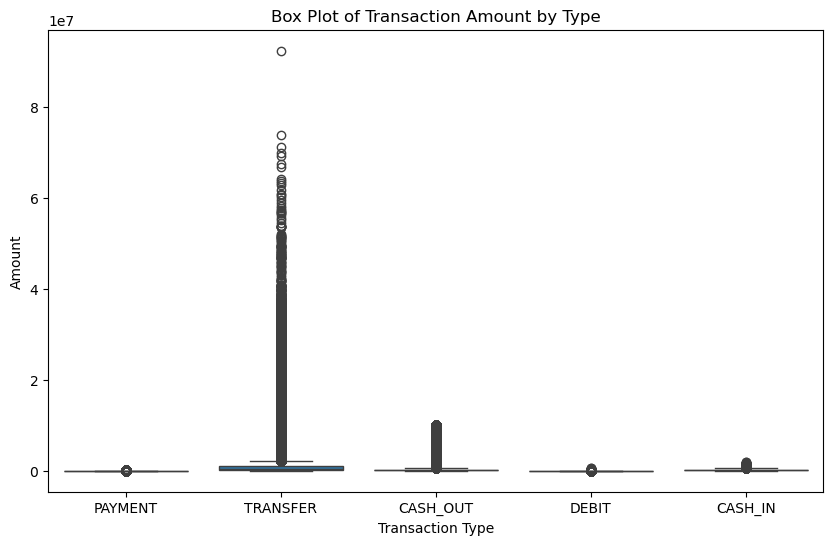

In [19]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='amount', data=df)
plt.title('Box Plot of Transaction Amount by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.show()

Inferences
* TRANSFER and CASH_OUT transactions have significantly higher and more varied amounts, with many extreme outliers. These types are likely targets for fraudulent activities due to high-value movements.

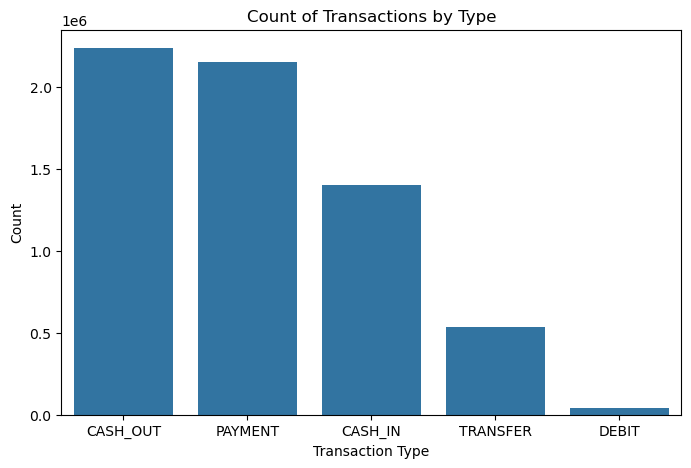

In [20]:
# Count plot
plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('Count of Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

Inferences
* CASH_OUT and PAYMENT dominate transaction volume, followed by CASH_IN, while TRANSFERs are relatively less frequent and DEBITs are rare. Given the low count but potentially high-value nature of TRANSFERs, they warrant focused fraud monitoring despite their smaller share.

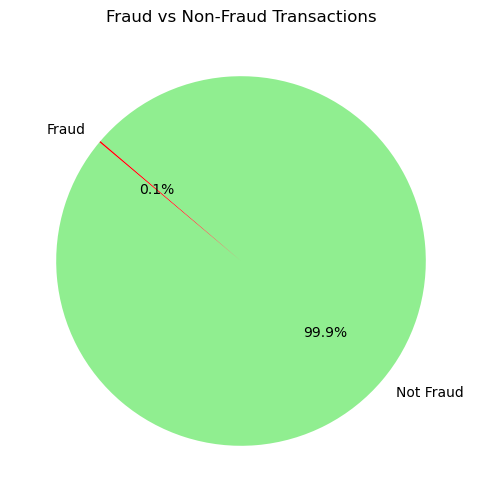

In [21]:
# pie Chart
fraud_counts = df['isFraud'].value_counts()
labels = ['Not Fraud', 'Fraud']
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'red'])
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

Inferences
* The dataset is highly imbalanced — only 0.1% of transactions are fraudulent. 

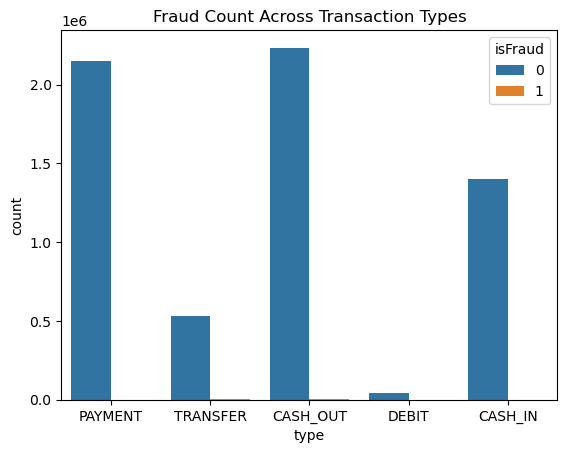

In [22]:
# Count plot
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraud Count Across Transaction Types')
plt.show()

Infereneces
* Fraudulent transactions occur almost exclusively in TRANSFER and CASH_OUT types. Other types (PAYMENT, CASH_IN, DEBIT) show virtually no fraud, indicating these two types should be prioritized for fraud detection.

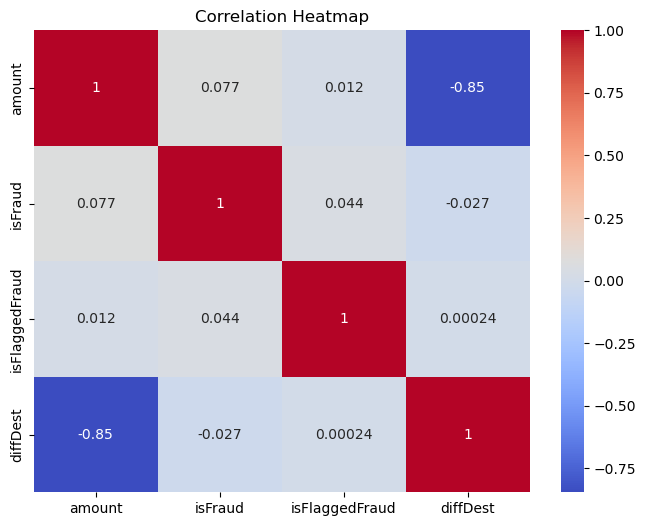

In [23]:
# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['amount', 'isFraud', 'isFlaggedFraud', 'diffDest']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Inferences
* amount and diffDest are strongly negatively correlated (-0.85), suggesting larger transactions often reduce the destination balance significantly. However, none of the features show strong linear correlation with isFraud

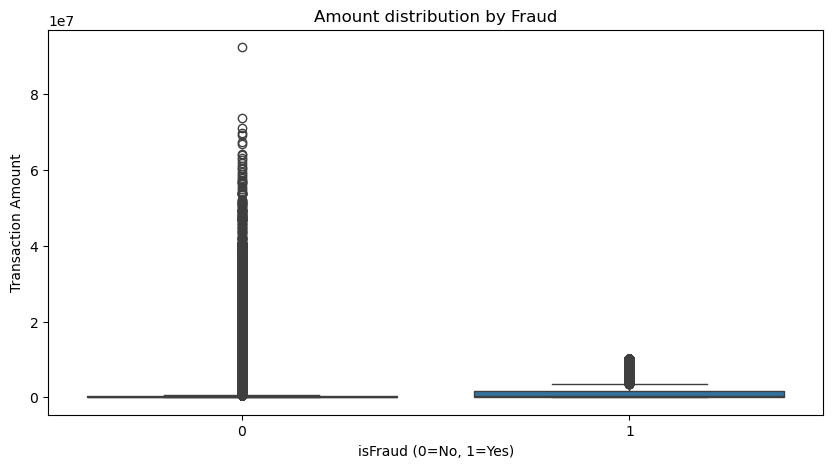

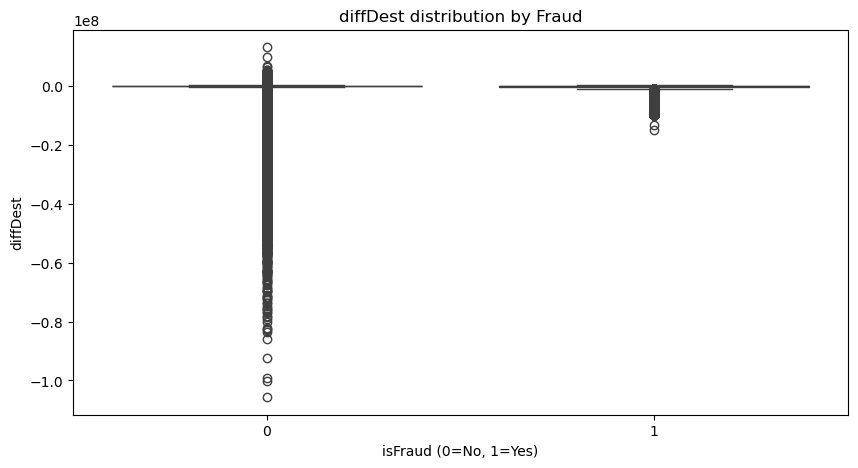

In [24]:
# Box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Amount distribution by Fraud')
plt.xlabel('isFraud (0=No, 1=Yes)')
plt.ylabel('Transaction Amount')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='isFraud', y='diffDest', data=df)
plt.title('diffDest distribution by Fraud')
plt.xlabel('isFraud (0=No, 1=Yes)')
plt.ylabel('diffDest')
plt.show()


Inferences
* Fraudulent transactions tend to involve higher amounts compared to non-fraudulent ones.
* For fraud cases, diffDest values are consistently negative, suggesting the recipient’s balance did not increase — a strong indicator of money being siphoned off or not credited properly.

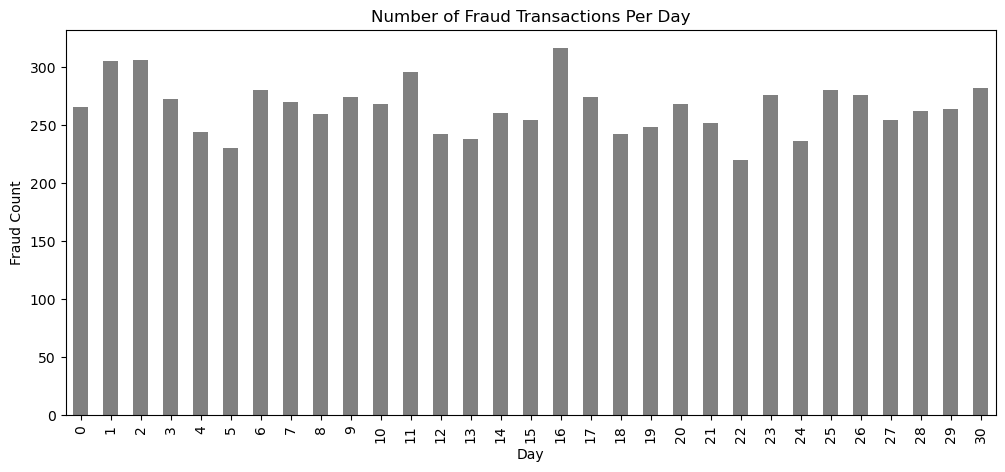

In [25]:
# Bar plot
df['day'] = df['step'] // 24
fraud_per_day = df.groupby('day')['isFraud'].sum()

plt.figure(figsize=(12, 5))
fraud_per_day.plot(kind='bar', color='grey')
plt.title('Number of Fraud Transactions Per Day')
plt.xlabel('Day')
plt.ylabel('Fraud Count')
plt.show()



Inferences
* Fraudulent transactions occur consistently across all 30 days, with no major spikes or drops. This suggests fraud attempts are systematic and ongoing, rather than isolated to specific dates.

In [26]:
df=df.drop(columns=['day'])

In [27]:
# Encoding

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [28]:
# Splitting data 

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  random_state=42)

In [29]:
# Scaling and applying SMOTE

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


#### Base model Building

#### RandomForest

In [47]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=80, max_depth=4)
rf_model.fit(X_train_resampled, y_train_resampled)

# Train predictions
y_pred_train_rf = rf_model.predict(X_train_resampled)

# Test predictions
y_pred_test_rf = rf_model.predict(X_test_scaled)

print("Training Accuracy:", accuracy_score(y_train_resampled, y_pred_train_rf))
print("\nTraining Classification Report:\n", classification_report(y_train_resampled, y_pred_train_rf))
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train_resampled, y_pred_train_rf))

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_test_rf))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_rf))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))


Training Accuracy: 0.9047072473907702

Training Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91   4448056
           1       0.95      0.86      0.90   4448056

    accuracy                           0.90   8896112
   macro avg       0.91      0.90      0.90   8896112
weighted avg       0.91      0.90      0.90   8896112


Training Confusion Matrix:
 [[4237135  210921]
 [ 636814 3811242]]

Test Accuracy: 0.9524362605341825

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98   1906351
           1       0.02      0.85      0.04      2435

    accuracy                           0.95   1908786
   macro avg       0.51      0.90      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786


Test Confusion Matrix:
 [[1815920   90431]
 [    358    2077]]


#### XGBoost

In [48]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Train predictions
y_pred_train_xgb = xgb_model.predict(X_train_resampled)

# Test predictions
y_pred_test_xgb = xgb_model.predict(X_test_scaled)

print("Training Accuracy:", accuracy_score(y_train_resampled, y_pred_train_xgb))
print("\nTraining Classification Report:\n", classification_report(y_train_resampled, y_pred_train_xgb))
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train_resampled, y_pred_train_xgb))

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_test_xgb))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_xgb))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_xgb))


Training Accuracy: 0.9555456361160921

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96   4448056
           1       0.97      0.94      0.95   4448056

    accuracy                           0.96   8896112
   macro avg       0.96      0.96      0.96   8896112
weighted avg       0.96      0.96      0.96   8896112


Training Confusion Matrix:
 [[4329912  118144]
 [ 277327 4170729]]

Test Accuracy: 0.9732945442810247

Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1906351
           1       0.04      0.89      0.08      2435

    accuracy                           0.97   1908786
   macro avg       0.52      0.93      0.53   1908786
weighted avg       1.00      0.97      0.99   1908786


Test Confusion Matrix:
 [[1855646   50705]
 [    270    2165]]


#### LightGBM

In [51]:

lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train_resampled, y_train_resampled)

# Train predictions
y_pred_train_lgb = lgb_model.predict(X_train_resampled)

# Test predictions
y_pred_test_lgb = lgb_model.predict(X_test_scaled)

print("Training Accuracy:", accuracy_score(y_train_resampled, y_pred_train_lgb))
print("\nTraining Classification Report:\n", classification_report(y_train_resampled, y_pred_train_lgb))
print("\nTraining Confusion Matrix:\n", confusion_matrix(y_train_resampled, y_pred_train_lgb))

print("\nTest Accuracy:", accuracy_score(y_test, y_pred_test_lgb))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_test_lgb))
print("\nTest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_lgb))


[LightGBM] [Info] Number of positive: 4448056, number of negative: 4448056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 8896112, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training Accuracy: 0.9469186089383766

Training Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95   4448056
           1       0.97      0.92      0.95   4448056

    accuracy                           0.95   8896112
   macro avg       0.95      0.95      0.95   8896112
weighted avg       0.95      0.95      0.95   8896112


Training Confusion Matrix:
 [[4309690  138366]
 [ 333852 4114204]]

Test Accuracy: 0.96883359

#### Hyperparameter Tunning

In [30]:
# Sample 10% for tuning ( because dataset is too large)

# Convert to DataFrame 
X_train_resampled_df = pd.DataFrame(X_train_resampled)
y_train_resampled_df = pd.Series(y_train_resampled)

# Sample 10% of the training data
sampled_X = X_train_resampled_df.sample(frac=0.1, random_state=42)
sampled_y = y_train_resampled_df.loc[sampled_X.index]


**Tuned Random forest**

In [59]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search CV on 10% data
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy', cv=3,
                                   verbose=1, random_state=42, n_jobs=-1)

random_search.fit(sampled_X, sampled_y)

best_params = random_search.best_params_

final_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_xgb.fit(X_train_resampled, y_train_resampled)

y_pred_train = final_xgb.predict(X_train_resampled)
y_pred_test = final_xgb.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_train_resampled, y_pred_train))
print("Classification Report:\n", classification_report(y_train_resampled, y_pred_train))
print("Confusion Matrix:\n", confusion_matrix(y_train_resampled, y_pred_train))

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy: 0.9613126498407394
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96   4448056
           1       0.97      0.95      0.96   4448056

    accuracy                           0.96   8896112
   macro avg       0.96      0.96      0.96   8896112
weighted avg       0.96      0.96      0.96   8896112

Confusion Matrix:
 [[4329076  118980]
 [ 225187 4222869]]
Accuracy: 0.9730525056239935
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99   1906351
           1       0.04      0.88      0.08      2435

    accuracy                           0.97   1908786
   macro avg       0.52      0.93      0.53   1908786
weighted avg       1.00      0.97      0.99   1908786

Confusion Matrix:
 [[1855209   51142]
 [    295    2140]]


**Tuned XGB**

In [36]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model on sampled data
random_search.fit(sampled_X, sampled_y)

# Best estimator
best_xgb = random_search.best_estimator_

# Predict probabilities
y_proba_train = best_xgb.predict_proba(X_train_resampled_df)[:, 1]
y_proba_test = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Find best threshold on training data
prec, rec, thresholds = precision_recall_curve(y_train_resampled_df, y_proba_train)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply best threshold to get final predictions
y_pred_train = (y_proba_train >= best_threshold).astype(int)
y_pred_test = (y_proba_test >= best_threshold).astype(int)

print("Train Metrics:")
print("Accuracy:", accuracy_score(y_train_resampled_df, y_pred_train))
print("F1 Score:", f1_score(y_train_resampled_df, y_pred_train))
print("Classification Report:\n", classification_report(y_train_resampled_df, y_pred_train, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_train_resampled_df, y_pred_train))

print("\nTest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Train Metrics:
Accuracy: 0.9499707287857887
F1 Score: 0.9497214416080246
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95   4448056
           1       0.95      0.95      0.95   4448056

    accuracy                           0.95   8896112
   macro avg       0.95      0.95      0.95   8896112
weighted avg       0.95      0.95      0.95   8896112

Confusion Matrix:
 [[4247577  200479]
 [ 244587 4203469]]

Test Metrics:
Accuracy: 0.9547880170956828
F1 Score: 0.04955947136563876
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98   1906351
           1       0.03      0.92      0.05      2435

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.98   1908786

Confusion Matrix:
 [[1820236   8

**Tuned LightGBM**

In [35]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'num_leaves': [20, 31, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize model
model = LGBMClassifier(random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='f1_weighted',
                                   cv=3,
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# Fit on 10% sampled SMOTE-resampled data
random_search.fit(sampled_X, sampled_y)

# Best model
best_lgb = random_search.best_estimator_

# Get predicted probabilities instead of class labels
y_proba_train = best_lgb.predict_proba(X_train_scaled)[:, 1]
y_proba_test = best_lgb.predict_proba(X_test_scaled)[:, 1]

# Using precision-recall curve to find best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best threshold based on F1 score: {best_threshold:.3f}")

# Applying threshold to get final predictions
y_pred_train = (y_proba_train >= best_threshold).astype(int)
y_pred_test = (y_proba_test >= best_threshold).astype(int)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Train Classification Report:\n", classification_report(y_train, y_pred_train, zero_division=0))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Test Classification Report:\n", classification_report(y_test, y_pred_test, zero_division=0))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 444796, number of negative: 444815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 889611, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000043
[LightGBM] [Info] Start training from score -0.000043
Best threshold based on F1 score: 0.989
Train Accuracy: 0.9995359054693103
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448056
           1       0.89      0.73      0.80      5778

    accuracy                           1.00   4453834
   macro avg       0.95      0.86      0.90   4453834
wei